# Trabalhando com Dados Customizados

Até aqui, trabalhamos somente com dados já formatados pelo Keras.

Vamos ver como é trabalhar com um dataset real.


## Os Dados - Kaggle Competition: Cats and Dogs

-----------

The Kaggle Competition: [Cats and Dogs](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

Os dados incluem 25.000 imagens de cães e gatos. Construiremos um classificador que trabalha com essas imagens e capaz de identificar cães e gatos.

As imagens estão numeradas de 0-12499 tanto para gatos, quanto cachorros. Logo, 25K imagens.

-----------


**Nota: Trabalharemos com arquivos de imagem, NÃO numpy arrays. Grande parte do processo consiste em aprender como trabalhar e lidar com grandes grupos de arquivos de imagem. Os dados são muito grandes para armazenar em memória como um numpy array, então, teremos que alimentar nosso modelo em lotes. **

### Visualizando os dados.

In [1]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
cat1 = cv2.imread('CATS_DOGS/train/CAT/1.jpg')
cat1 = cv2.cvtColor(cat1,cv2.COLOR_BGR2RGB,0)

error: OpenCV(4.1.1) /home/cursocv/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
type(cat1)

In [ ]:
cat1.shape

In [ ]:
plt.imshow(cat1)

In [ ]:
dog2 = cv2.imread('CATS_DOGS/train/DOG/2.jpg')
dog2 = cv2.cvtColor(dog2,cv2.COLOR_BGR2RGB)

In [ ]:
dog2.shape

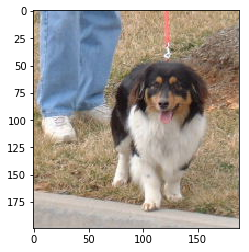

In [86]:
plt.imshow(dog2)

## Preparando os Dados para o Modelo

Como há muitos dados para ler em memória, podemos usar algumas funções do Keras para processar os dados, gerar um fluxo em lotes a partir de um diretório, bem como manipular as imagens.

### Manipulação de Imagens - Data Augmentation (Básico)

Normalmente é uma boa ideia manipular as imagens com rotação, escala, etc. Assim, conseguimos tornar nosso modelo mais robusto, gerando imagens diferentes. **ImageDataGenerator** é capaz de fazer isto automaticamente!

In [94]:
from keras.preprocessing.image import ImageDataGenerator

In [95]:
image_gen = ImageDataGenerator(rotation_range=30, # rotaciona a imagem 30 graus
                               width_shift_range=0.1, # Move a imagem em largura em 10%
                               height_shift_range=0.1, # Move a imagem em altura em 10%
                               rescale=1/255, # Reescala a imagem através da normalização
                               shear_range=0.2, # Shear consiste em cortar parte da imagem (max 20%)
                               zoom_range=0.2, # Zoom in (20% max)
                               horizontal_flip=True, # Permite virar na horizontal
                               fill_mode='nearest' # Preenche os pixels faltantes com o valor mais próximo
                              )

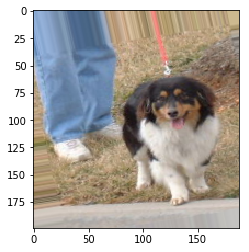

In [96]:
plt.imshow(image_gen.random_transform(dog2))

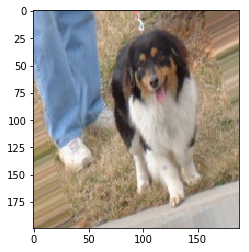

In [97]:
plt.imshow(image_gen.random_transform(dog2))

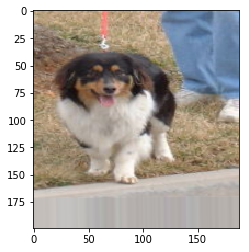

In [98]:
plt.imshow(image_gen.random_transform(dog2))

### Gerando muitas imagens manipuladas a partir de um diretório.


Para usar o .flow_from_directory, você precisa organizar as imagens em sub-diretórios. Os diretórios devem conter apenas imagens de uma classe, logo, uma pasta por classe de imagens...

Estrutura:

* Pasta de Imagens
    * Classe 1
        * 0.jpg
        * 1.jpg
        * ...
    * Classe 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Classe n

In [99]:
image_gen.flow_from_directory('CATS_DOGS/train')

Found 18743 images belonging to 2 classes.


In [100]:
image_gen.flow_from_directory('CATS_DOGS/test')

Found 6251 images belonging to 2 classes.


### Redimensionando Imagens

Vamos fazer com que o Keras redimensione todas as imagens para 150x150.

In [101]:
# width,height,channels
image_shape = (150,150,3)

# Criando o Modelo

In [102]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [105]:
modelo = Sequential()

modelo.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
modelo.add(MaxPooling2D(pool_size=(2, 2)))

modelo.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
modelo.add(MaxPooling2D(pool_size=(2, 2)))

modelo.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
modelo.add(MaxPooling2D(pool_size=(2, 2)))


modelo.add(Flatten())


modelo.add(Dense(128))
modelo.add(Activation('relu'))

# Dropouts ajuda reduzir overfitting por desligar Neurons aleatóriamente durante o treinamento.
# Aqui dizemos para desligar 50% de maneira aleatória.
modelo.add(Dropout(0.5))

# Última camada, lembrando: 0=cat , 1=dog
modelo.add(Dense(1))
modelo.add(Activation('sigmoid'))

modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [107]:
modelo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)             0         
__________

### Treinando o Modelo

In [108]:
batch_size = 16

treina_image_gen = image_gen.flow_from_directory('CATS_DOGS/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 18743 images belonging to 2 classes.


In [109]:
teste_image_gen = image_gen.flow_from_directory('CATS_DOGS/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 6251 images belonging to 2 classes.


In [110]:
treina_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
#HORA DO INTERVALO
results = model.fit_generator(treina_image_gen,epochs=100,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/100
150/150 [==============================] - 92s 611ms/step - loss: 0.7018 - acc: 0.5150 - val_loss: 0.6838 - val_acc: 0.4792
Epoch 2/100
150/150 [==============================] - 86s 576ms/step - loss: 0.6879 - acc: 0.5567 - val_loss: 0.6678 - val_acc: 0.5938
Epoch 3/100
 28/150 [====>.........................] - ETA: 1:10 - loss: 0.6821 - acc: 0.5424

KeyboardInterrupt: 

In [25]:
# model.save('cat_dog2.h5')

# Testando o Modelo

In [ ]:
results.history['acc']

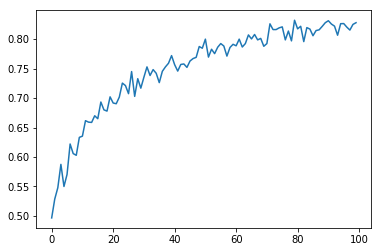

In [27]:
plt.plot(results.history['acc'])

In [28]:
# model.save('cat_dog_100epochs.h5')

# Prevendo novas imagens

In [3]:
treina_image_gen.class_indices

NameError: name 'treina_image_gen' is not defined

In [4]:
import numpy as np
from keras.preprocessing import image

dog_file = 'CATS_DOGS/train/DOG/2.jpg'

dog_img = image.load_img(dog_file, target_size=(150, 150))

dog_img = image.img_to_array(dog_img)

dog_img = np.expand_dims(dog_img, axis=0)
dog_img = dog_img/255

Using TensorFlow backend.
/home/cursocv/.virtualenvs/cursocv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cursocv/.virtualenvs/cursocv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cursocv/.virtualenvs/cursocv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cursocv/.virtu

FileNotFoundError: [Errno 2] No such file or directory: 'CATS_DOGS/train/DOG/2.jpg'

In [ ]:
prediction_prob = model.predict(dog_img)

In [ ]:
# Output prediction
print(f'Probabilidade de ser um cão: {prediction_prob} ')